In [1]:
!pip install shap==0.40.0

     |████████████████████████████████| 371 kB 7.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for shap: filename=shap-0.40.0-cp37-cp37m-linux_x86_64.whl size=509243 sha256=72bfafd09cfef38f392e637e1d5466cef962a49abb7d567b20ac15987ac673f2
  Stored in directory: /root/.cache/pip/wheels/ec/35/84/e304841ac4b910bc95fe9a6e5302eb2507b4333728851dcbfb
Successfully built shap


In [2]:
# Commonly used modules
import numpy as np
import os
import sys

# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import cv2
import IPython

from six.moves import urllib

# Import the SHAP library - https://github.com/slundberg/shap
import shap

import xgboost
import tensorflow as tf


## For Regression task

Load the Boston Housing dataset.

In [3]:
(train_features, train_labels), (test_features, test_labels) = tf.keras.datasets.boston_housing.load_data()
features = [('CRIM', 'crime_rate'), ('ZN', 'residential_zone'),
            ('INDUS', 'prop_non-retail'), ('CHAS', 'river_adjacent'),
            ('NOX', 'NO_concentration'), ('RM', 'avg_rooms'),
            ('AGE', 'age'), ('DIS', 'employment_proximit'),
            ('RAD', 'radial_highways'), ('TAX', 'tax_rate'),
            ('PTRATIO', 'pupil-teacher_ratio'), ('B', 'prop_black'),
            ('LSTAT', 'lower_status_pop')]
df_train_features = pd.DataFrame(train_features, columns=[feature[0] for feature in features])
df_train_labels = pd.DataFrame({'MEDV': train_labels})
pd.concat((df_train_features, df_train_labels), axis=1)

df_test_features = pd.DataFrame(test_features, columns=[feature[0] for feature in features])
df_test_labels = pd.DataFrame({'MEDV': test_labels})
pd.concat((df_test_features, df_test_labels), axis=1)

# get per-feature statistics (mean, standard deviation) from the training set to normalize by
def normalize(np_array):
  array_mean = np.mean(np_array, axis=0)
  array_std = np.std(np_array, axis=0)
  return (np_array - array_mean) / array_std

# train_features = normalize(train_features)
# test_features = normalize(test_features)

65536/57026 [==================================] - 0s 0us/step


In [4]:
pd.concat((df_train_features, df_train_labels), axis=1)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,1.23247,0.0,8.14,0.0,0.5380,6.142,91.7,3.9769,4.0,307.0,21.0,396.90,18.72,15.2
1,0.02177,82.5,2.03,0.0,0.4150,7.610,15.7,6.2700,2.0,348.0,14.7,395.38,3.11,42.3
2,4.89822,0.0,18.10,0.0,0.6310,4.970,100.0,1.3325,24.0,666.0,20.2,375.52,3.26,50.0
3,0.03961,0.0,5.19,0.0,0.5150,6.037,34.5,5.9853,5.0,224.0,20.2,396.90,8.01,21.1
4,3.69311,0.0,18.10,0.0,0.7130,6.376,88.4,2.5671,24.0,666.0,20.2,391.43,14.65,17.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399,0.21977,0.0,6.91,0.0,0.4480,5.602,62.0,6.0877,3.0,233.0,17.9,396.90,16.20,19.4
400,0.16211,20.0,6.96,0.0,0.4640,6.240,16.3,4.4290,3.0,223.0,18.6,396.90,6.59,25.2
401,0.03466,35.0,6.06,0.0,0.4379,6.031,23.3,6.6407,1.0,304.0,16.9,362.25,7.83,19.4
402,2.14918,0.0,19.58,0.0,0.8710,5.709,98.5,1.6232,5.0,403.0,14.7,261.95,15.79,19.4


In [5]:
# Numerical Variables
num_vars = ['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
           'TAX', 'PTRATIO', 'B', 'LSTAT']

# Categorical variables
cat_vars = ['CHAS']

# X = df[num_vars + cat_vars]

# Label
# y = df['MEDV']

# TF

Build a TF model for use with SHAP

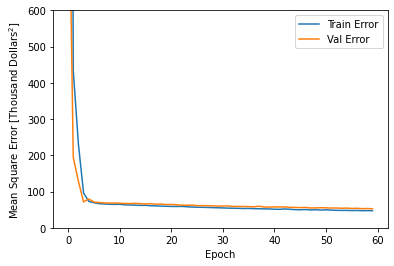

In [6]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(40, activation=tf.nn.relu, input_shape=[len(train_features[0])]),
        tf.keras.layers.Dense(20, activation=tf.nn.relu),
        tf.keras.layers.Dense(1)
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(), 
                  loss='mse',
                  metrics=['mae', 'mse'])
    return model

def plot_history():
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [Thousand Dollars$^2$]')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'], label = 'Val Error')
    plt.legend()
    plt.ylim([0,600])

model = build_model()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
history = model.fit(train_features, train_labels, epochs=60, verbose=0,
                    validation_data = (test_features, test_labels),
                    callbacks=[early_stopping]
                   )

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

plot_history()

# XGBoost

Build the XGBoost model

In [7]:
# from sklearn.datasets import fetch_california_housing
# housing = fetch_california_housing()
X, y = shap.datasets.boston()

model = xgboost.XGBRegressor(objective='reg:squarederror', n_estimators=1000)
model.fit(X, y)

Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.
    :func:`~sklearn.datasets.fetch_california_housing`) and the Ames housing
    datas

XGBRegressor(n_estimators=1000, objective='reg:squarederror')

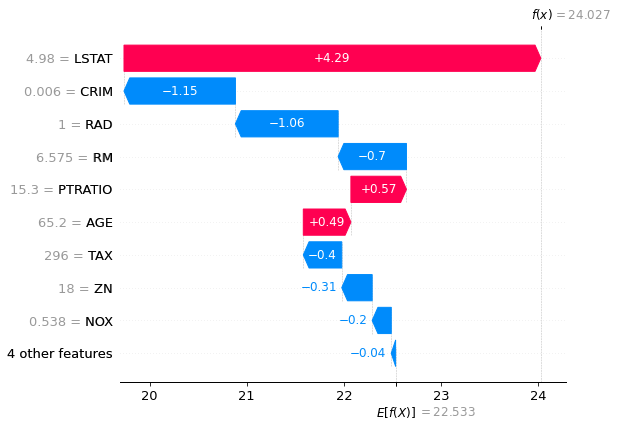

In [8]:
explainer = shap.Explainer(model)
shap_values = explainer(X)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

In [9]:
# visualize the first prediction's explanation with a force plot
shap.initjs()
shap.plots.force(shap_values[0])

In [29]:
first_row_shap = shap_values[0]
shapley_values = first_row_shap.values

print(f'Predicted Value: {first_row_shap.base_values + sum(shapley_values)}\n')
print(f'Baseline: {first_row_shap.base_values}\n')

print('Shapley values for features:')
for i, shapley_value in enumerate(shapley_values):
  print(f'{shap_values.feature_names[i]}: {shapley_value}')

print('\nMost to least influential features:')
most_influential_ordering = np.argsort(-np.abs(shapley_values))
for i in range(len(shapley_values)):
  print(f'{shap_values.feature_names[most_influential_ordering[i]]}: {shapley_values[most_influential_ordering[i]]}')


Predicted Value: 24.026760725304484

Baseline: 22.532655715942383

Shapley values for features:
CRIM: -1.146835207939148
ZN: -0.31299006938934326
INDUS: 0.061376914381980896
CHAS: -0.021838882938027382
NOX: -0.19653287529945374
RM: -0.7030439972877502
AGE: 0.4897627532482147
DIS: -0.13971006870269775
RAD: -1.0569021701812744
TAX: -0.3957155644893646
PTRATIO: 0.5716765522956848
B: 0.05542653053998947
LSTAT: 4.289431095123291

Most to least influential features:
LSTAT: 4.289431095123291
CRIM: -1.146835207939148
RAD: -1.0569021701812744
RM: -0.7030439972877502
PTRATIO: 0.5716765522956848
AGE: 0.4897627532482147
TAX: -0.3957155644893646
ZN: -0.31299006938934326
NOX: -0.19653287529945374
DIS: -0.13971006870269775
INDUS: 0.061376914381980896
B: 0.05542653053998947
CHAS: -0.021838882938027382


In [28]:
shap_values[0]

.values =
array([-1.1468352 , -0.31299007,  0.06137691, -0.02183888, -0.19653288,
       -0.703044  ,  0.48976275, -0.13971007, -1.0569022 , -0.39571556,
        0.57167655,  0.05542653,  4.289431  ], dtype=float32)

.base_values =
22.532656

.data =
array([6.320e-03, 1.800e+01, 2.310e+00, 0.000e+00, 5.380e-01, 6.575e+00,
       6.520e+01, 4.090e+00, 1.000e+00, 2.960e+02, 1.530e+01, 3.969e+02,
       4.980e+00])

In [11]:
# visualize all the training set predictions
shap.initjs()
shap.plots.force(shap_values)

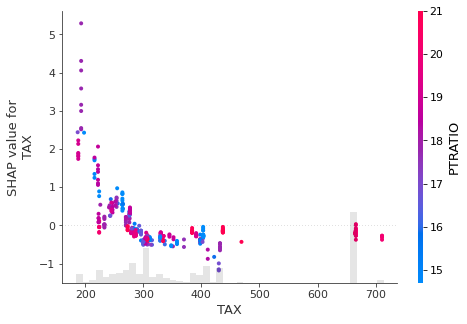

In [22]:
shap.plots.scatter(shap_values[:,"TAX"], color=shap_values)

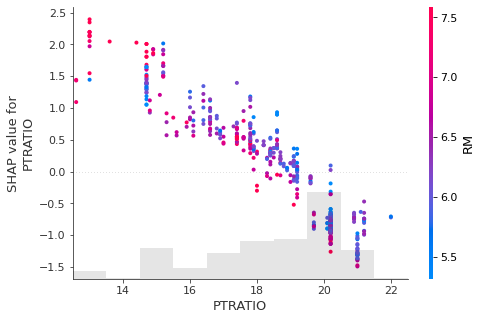

In [23]:
shap.plots.scatter(shap_values[:,"PTRATIO"], color=shap_values)

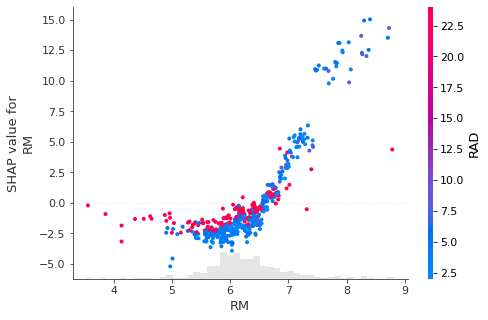

In [24]:
shap.plots.scatter(shap_values[:,"RM"], color=shap_values)

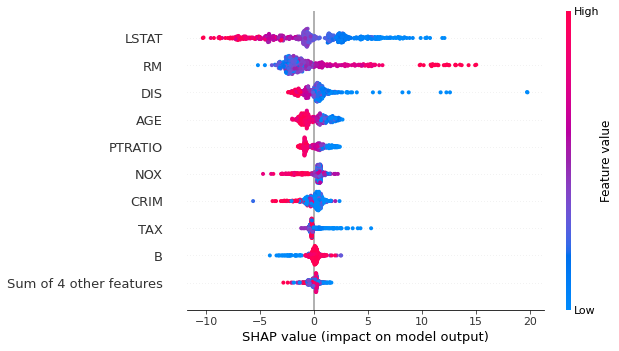

In [25]:
shap.plots.beeswarm(shap_values)

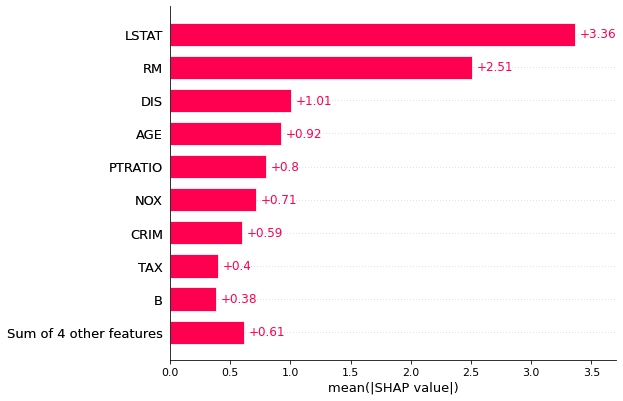

In [26]:
shap.plots.bar(shap_values)

# SHAP

Setup SHAP to work with our model

In [36]:
explainer = shap.Explainer(model)
shap_values = explainer([test_features[0]])

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

TypeError: ignored

In [34]:
# df_test_features.iloc[10,:].toarray()
test_features[0]

array([ 18.0846,   0.    ,  18.1   ,   0.    ,   0.679 ,   6.434 ,
       100.    ,   1.8347,  24.    , 666.    ,  20.2   ,  27.25  ,
        29.05  ])